# 1st model

In [16]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import time
import joblib
from datetime import timedelta
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
def load_data(file_path):
    data = pd.read_csv(file_path, parse_dates=['Unnamed: 0'], index_col=['Unnamed: 0'])
    data.index = pd.to_datetime(data.index)
    return data

## Initial Cleaning and Basic Imputation

In [3]:
# Utility function to check for NaNs
def check_for_nans(data, stage_name):
    if isinstance(data, pd.DataFrame):
        nan_counts = data.isna().sum()
    else:  # Assume numpy array
        nan_counts = pd.Series(np.isnan(data).sum(axis=0), index=range(data.shape[1]))

    if nan_counts.sum() > 0:
        print(f"WARNING: NaN values found after {stage_name}")
        print(nan_counts[nan_counts > 0])
        raise ValueError(f"NaN values present after {stage_name}. Please review the preprocessing steps.")
    else:
        print(f"No NaN values found after {stage_name}")


In [4]:
def initial_cleaning(df, extreme_missing_threshold=0.5):
    missing_percentages = df.isnull().mean()
    features_to_drop = missing_percentages[missing_percentages > extreme_missing_threshold].index
    return df.drop(columns=features_to_drop)

In [5]:
def basic_imputation(df):
    df = df.copy()
    for col in df.columns:
        if df[col].dtype.kind in 'fiu':  # float, integer, unsigned integer
            df[col].fillna(df[col].median(), inplace=True)
        elif df[col].dtype == 'object':
            df[col].fillna(df[col].mode()[0], inplace=True)
    return df

In [6]:
# data_initial_clean = initial_cleaning(data)
# data_basic_imputed = basic_imputation(data_initial_clean)

In [7]:
# print("Data shape after initial cleaning:", data_initial_clean.shape)
# print("Data shape after basic imputation:", data_basic_imputed.shape)

## Feature Engineering

In [8]:
def engineer_features(df):
    df = df.copy()

    # Wind speed bins
    df['WindSpeedBin'] = pd.cut(df['WindSpeed'], bins=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

    # Wind speed change
    df['WindSpeedChange'] = df['WindSpeed'].diff()

    # Rolling averages
    for window in ['1h', '24h']:
        df[f'WindSpeed_{window}_avg'] = df['WindSpeed'].rolling(window=window).mean()

    # Time-based features
    df['Hour'] = df.index.hour
    df['DayOfWeek'] = df.index.dayofweek

    # Interaction terms
    for rpm_feature in ['RotorRPM', 'GeneratorRPM']:
        if rpm_feature in df.columns and 'WindSpeed' in df.columns:
            df[f'WindSpeed_{rpm_feature}'] = df['WindSpeed'] * df[rpm_feature]

    # Power-related features
    if 'ActivePower' in df.columns:
        for window in ['1h', '24h']:
            df[f'ActivePower_{window}_avg'] = df['ActivePower'].rolling(window=window).mean()

    return df

In [9]:
def clean_and_impute_data(df, missing_threshold=0.2):
    # Remove 'ControlBoxTemperature' and 'WTG' columns
    columns_to_drop = ['ControlBoxTemperature', 'WTG']
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

    # Handle negative and zero values in ActivePower
    if 'ActivePower' in df.columns:
        df.loc[df['ActivePower'] < 0, 'ActivePower'] = 0
        small_constant = 0.1
        df.loc[df['ActivePower'] == 0, 'ActivePower'] = small_constant

    # Remove features with high missing values
    missing_percentages = df.isnull().mean()
    features_to_drop = missing_percentages[missing_percentages > missing_threshold].index
    df = df.drop(columns=features_to_drop)

    # Impute remaining missing values
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    categorical_columns = df.select_dtypes(exclude=[np.number]).columns

    for column in df.columns:
        if df[column].isnull().sum() > 0:
            if column in numeric_columns:
                if df[column].isnull().sum() / len(df) < 0.05:
                    df[column].fillna(df[column].median(), inplace=True)
                else:
                    imputer = KNNImputer(n_neighbors=5)
                    df[column] = imputer.fit_transform(df[[column]])
            elif column in categorical_columns:
                df[column].fillna(df[column].mode()[0], inplace=True)

    return df

In [10]:
def prepare_data_for_xgboost(X, y):
    X = X.copy()
    for col in X.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
    if 'WindSpeedBin' in X.columns:
        X['WindSpeedBin'] = X['WindSpeedBin'].astype('category')
    return X, y

In [11]:
def train_evaluate_model(X_train, X_test, y_train, y_test):
    X_train, y_train = prepare_data_for_xgboost(X_train, y_train)
    X_test, y_test = prepare_data_for_xgboost(X_test, y_test)

    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
    dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

    params = {
        'max_depth': 6,
        'eta': 0.3,
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse'
    }

    num_round = 200
    evallist = [(dtrain, 'train'), (dtest, 'eval')]
    model = xgb.train(params, dtrain, num_round, evallist, early_stopping_rounds=50, verbose_eval=False)

    pred = model.predict(dtest)

    metrics = {
        'R2': r2_score(y_test, pred),
        'MAE': mean_absolute_error(y_test, pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, pred))
    }

    return model, metrics

In [12]:
# Load and preprocess data
data = load_data('/content/drive/MyDrive/TurbinData/Turbine_Data.csv')
data_initial_clean = initial_cleaning(data)
data_basic_imputed = basic_imputation(data_initial_clean)
data_engineered = engineer_features(data_basic_imputed)
data_final_clean = clean_and_impute_data(data_engineered)

In [13]:
# Check for NaNs after preprocessing
check_for_nans(data_final_clean, "Model 1 preprocessing")

No NaN values found after Model 1 preprocessing


In [14]:
# Prepare data for modeling
features = [col for col in data_final_clean.columns if col != 'ActivePower']
X = data_final_clean[features]
y = data_final_clean['ActivePower']

In [15]:
# Check for NaNs in features and target
check_for_nans(X, "feature extraction in Model 1")
check_for_nans(pd.DataFrame(y), "target extraction in Model 1")

No NaN values found after feature extraction in Model 1
No NaN values found after target extraction in Model 1


In [16]:
# Split data
split_point = int(len(X) * 0.8)
X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

In [17]:
# Train and evaluate Model 1
model1, metrics1 = train_evaluate_model(X_train, X_test, y_train, y_test)
print("\nModel 1 Metrics:")
for key, value in metrics1.items():
    print(f"{key}: {value}")

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



Model 1 Metrics:
R2: 0.9794821779164994
MAE: 18.329260779495343
RMSE: 62.92458015793272


In [18]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_predictions_interactive(y_true, y_pred, title):
    # Ensure y_true is a Series with a datetime index
    if not isinstance(y_true, pd.Series):
        y_true = pd.Series(y_true, index=y_true.index)

    # Create a DataFrame with actual and predicted values
    df = pd.DataFrame({'Actual': y_true, 'Predicted': y_pred})

    # Create the plot
    fig = make_subplots(rows=1, cols=1)

    # Add traces for actual and predicted values
    fig.add_trace(
        go.Scatter(x=df.index, y=df['Actual'], name='Actual', line=dict(color='blue'))
    )
    fig.add_trace(
        go.Scatter(x=df.index, y=df['Predicted'], name='Predicted', line=dict(color='red'))
    )

    # Update layout
    fig.update_layout(
        title=title,
        xaxis_title='Time',
        yaxis_title='Active Power',
        hovermode='x unified',
        legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1)
    )

    # Show the plot
    fig.show()

In [19]:
X_test_dmatrix = xgb.DMatrix(X_test, enable_categorical=True)
test_predictions = model1.predict(X_test_dmatrix)

plot_predictions_interactive(y_test, test_predictions, "Wind Turbine Active Power: Actual vs Predicted (Test Data)")

Output hidden; open in https://colab.research.google.com to view.

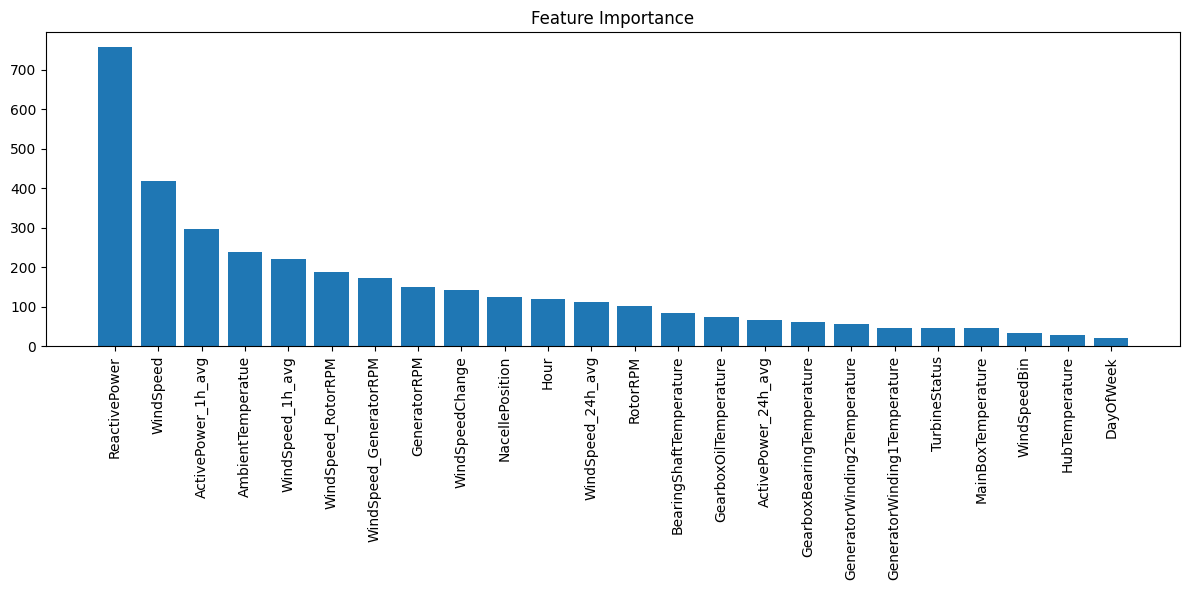

In [20]:
# Feature importance plot
importance = model1.get_score(importance_type='weight')
importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
plt.figure(figsize=(12, 6))
plt.bar(range(len(importance)), [val[1] for val in importance])
plt.xticks(range(len(importance)), [val[0] for val in importance], rotation=90)
plt.title("Feature Importance")
plt.tight_layout()
plt.show()

In [21]:
# Save model
joblib.dump(model1, "/content/drive/MyDrive/TurbinData/wind_turbine_model1.joblib")
print("model saved successfully.")

model saved successfully.


# 2nd model

In [22]:
def create_advanced_features(df):
    df = df.copy()

    # Time-based features
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter

    # Cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    # Lag features with forward fill
    df['lag_1d'] = df['ActivePower'].shift(24).fillna(method='ffill')
    df['lag_1w'] = df['ActivePower'].shift(168).fillna(method='ffill')

    # Rolling statistics with min_periods
    for window in [24, 168, 720]:
        df[f'rolling_mean_{window}h'] = df['ActivePower'].rolling(window=window, min_periods=1).mean()
        df[f'rolling_std_{window}h'] = df['ActivePower'].rolling(window=window, min_periods=1).std()

    # Seasonality decomposition
    from statsmodels.tsa.seasonal import seasonal_decompose

    # Interpolate missing values for decomposition
    active_power_interpolated = df['ActivePower'].interpolate()

    decomposition = seasonal_decompose(active_power_interpolated, model='additive', period=24*7)
    df['trend'] = decomposition.trend
    df['seasonal'] = decomposition.seasonal
    df['residual'] = decomposition.resid

    # Handle any remaining NaNs
    df = df.fillna(method='ffill').fillna(method='bfill')

    return df

In [23]:
# Create advanced features
data_advanced = create_advanced_features(data_final_clean)

<ipython-input-22-b614019872f8>:18: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

<ipython-input-22-b614019872f8>:19: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

<ipython-input-22-b614019872f8>:38: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [24]:
# Check for NaNs after creating advanced features
check_for_nans(data_advanced, "creating advanced features in Model 2")

No NaN values found after creating advanced features in Model 2


In [25]:
# Select features and target
features = ['hour', 'day', 'month', 'dayofweek', 'quarter',
            'hour_sin', 'hour_cos', 'month_sin', 'month_cos',
            'lag_1d', 'lag_1w',
            'rolling_mean_24h', 'rolling_std_24h',
            'rolling_mean_168h', 'rolling_std_168h',
            'rolling_mean_720h', 'rolling_std_720h',
            'trend', 'seasonal', 'residual']
target = 'ActivePower'

In [26]:
X = data_advanced[features]
y = data_advanced[target]

In [27]:
# Check for NaNs in features and target
check_for_nans(X, "feature extraction in Model 2")
check_for_nans(pd.DataFrame(y), "target extraction in Model 2")

No NaN values found after feature extraction in Model 2
No NaN values found after target extraction in Model 2


In [28]:
# Split the data
split_point = int(len(X) * 0.8)
X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

In [29]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [30]:
# Check for NaNs after scaling
check_for_nans(pd.DataFrame(X_train_scaled, columns=features), "scaling training data in Model 2")
check_for_nans(pd.DataFrame(X_test_scaled, columns=features), "scaling test data in Model 2")

No NaN values found after scaling training data in Model 2
No NaN values found after scaling test data in Model 2


In [31]:
# Hyperparameter tuning
param_space = {
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 500, 1000, 2000],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2, 0.3],
    'tree_method': ['hist'],
    'device': ['cuda']
}

In [32]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', tree_method='hist', device='cuda')
tscv = TimeSeriesSplit(n_splits=5)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_space,
    n_iter=100,
    cv=tscv,
    verbose=2,
    random_state=42,
    n_jobs=1
)

In [33]:
random_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning:

[03:13:47] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.




[CV] END colsample_bytree=0.7, device=cuda, gamma=0.3, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=500, subsample=0.8, tree_method=hist; total time=   1.5s
[CV] END colsample_bytree=0.7, device=cuda, gamma=0.3, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=500, subsample=0.8, tree_method=hist; total time=   0.9s
[CV] END colsample_bytree=0.7, device=cuda, gamma=0.3, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=500, subsample=0.8, tree_method=hist; total time=   1.0s
[CV] END colsample_bytree=0.7, device=cuda, gamma=0.3, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=500, subsample=0.8, tree_method=hist; total time=   1.0s
[CV] END colsample_bytree=0.7, device=cuda, gamma=0.3, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=500, subsample=0.8, tree_method=hist; total time=   1.1s
[CV] END colsample_bytree=0.9, device=cuda, gamma=0.3, learning_rate=0.05, max_depth=7, min_child_weight=7, n_

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device='cuda',
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric='rmse',
                                          feature_types=None, gamma=None,
                                          grow_polic...
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                   n_iter=100, n_jobs=1,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8,
                                                             0.9],
                                        'device': ['cuda'],
                                        'gamma': [0, 0.1, 0.2, 0.3],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 5, 7, 9],
                                        'min_child_weight': [1, 3, 5, 7],
                                        'n_estimators': [100, 500, 1000, 2000],
                                        'subsample': [0.6, 0.7, 0.8, 0.9],
                                        'tree_method': ['hist']},
                   random_state=42, verbose=2)

In [34]:
best_model = random_search.best_estimator_
print("Best parameters:", random_search.best_params_)

Best parameters: {'tree_method': 'hist', 'subsample': 0.7, 'n_estimators': 1000, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0.1, 'device': 'cuda', 'colsample_bytree': 0.9}


In [35]:
# Evaluate Model 2
y_pred = best_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel 2 Performance:")
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared Score: {r2}")


Model 2 Performance:
Mean Squared Error: 1749.0517856600827
Mean Absolute Error: 18.301470728732003
R-squared Score: 0.9909365556045846


In [36]:
# Plot feature importance
feature_importance = best_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = go.Figure(go.Bar(
    x=feature_importance[sorted_idx],
    y=[features[i] for i in sorted_idx],
    orientation='h'
))
fig.update_layout(
    title="Feature Importance (Advanced Model)",
    xaxis_title="Importance",
    yaxis_title="Features",
    height=800
)
fig.show()

In [37]:
# Plot actual vs predicted
fig = make_subplots(rows=1, cols=1)
fig.add_trace(
    go.Scatter(x=y_test.index, y=y_test.values, name="Actual", mode="lines")
)
fig.add_trace(
    go.Scatter(x=y_test.index, y=y_pred, name="Predicted", mode="lines")
)
fig.update_layout(
    title="Actual vs Predicted Active Power (Advanced Model)",
    xaxis_title="Date",
    yaxis_title="Active Power",
    height=600
)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [38]:
# Save model
joblib.dump(best_model, "/content/drive/MyDrive/TurbinData/wind_turbine_model2.joblib")
print("model saved successfully.")

model saved successfully.


# 3rd model

In [39]:
def select_features_and_evaluate(threshold, X_train, X_test, y_train, y_test, best_model, features):
    importances = best_model.feature_importances_

    if isinstance(threshold, str):
        if threshold.endswith('%'):
            percentile = float(threshold.rstrip('%'))
            threshold = np.percentile(importances, 100 - percentile)
        elif threshold == 'mean':
            threshold = np.mean(importances)
        elif threshold == 'median':
            threshold = np.median(importances)
        else:
            raise ValueError(f"Unsupported threshold type: {threshold}")

    mask = importances > threshold
    selected_features = [feature for feature, selected in zip(features, mask) if selected]
    X_train_selected = X_train[:, mask]
    X_test_selected = X_test[:, mask]

    xgb_selected = xgb.XGBRegressor(**best_model.get_params())
    xgb_selected.fit(X_train_selected, y_train)

    y_pred_selected = xgb_selected.predict(X_test_selected)
    mse_selected = mean_squared_error(y_test, y_pred_selected)
    r2_selected = r2_score(y_test, y_pred_selected)

    print(f"Threshold: {threshold}")
    print(f"Number of selected features: {len(selected_features)}")
    print("Selected features:", selected_features)
    print(f"MSE with selected features: {mse_selected}")
    print(f"R-squared with selected features: {r2_selected}")
    print("\n")

    return r2_selected, selected_features

In [40]:
# Try different thresholds
thresholds = ['mean', '75%', '50%', '25%', 0.01, 0.001]
results = {}

In [41]:
for threshold in thresholds:
    r2, selected_feats = select_features_and_evaluate(threshold, X_train_scaled, X_test_scaled, y_train, y_test, best_model, features)
    results[threshold] = {'R2': r2, 'Features': selected_feats}

Threshold: 0.04999999701976776
Number of selected features: 4
Selected features: ['rolling_mean_24h', 'rolling_mean_168h', 'trend', 'residual']
MSE with selected features: 1759.800363665246
R-squared with selected features: 0.990880857345746


Threshold: 0.0008632037788629532
Number of selected features: 15
Selected features: ['hour', 'month', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'lag_1d', 'rolling_mean_24h', 'rolling_std_24h', 'rolling_mean_168h', 'rolling_std_168h', 'rolling_mean_720h', 'trend', 'seasonal', 'residual']
MSE with selected features: 1715.9732715215482
R-squared with selected features: 0.9911079657801068


Threshold: 0.0025824737967923284
Number of selected features: 10
Selected features: ['hour', 'month', 'hour_cos', 'lag_1d', 'rolling_mean_24h', 'rolling_std_24h', 'rolling_mean_168h', 'rolling_mean_720h', 'trend', 'residual']
MSE with selected features: 1728.6378271754315
R-squared with selected features: 0.9910423390805988


Threshold: 0.01926792552694678

In [42]:
# Print summary
print("Summary of Results:")
for threshold, result in results.items():
    print(f"Threshold: {threshold}")
    print(f"R-squared: {result['R2']}")
    print(f"Number of features: {len(result['Features'])}")
    print("---")

Summary of Results:
Threshold: mean
R-squared: 0.990880857345746
Number of features: 4
---
Threshold: 75%
R-squared: 0.9911079657801068
Number of features: 15
---
Threshold: 50%
R-squared: 0.9910423390805988
Number of features: 10
---
Threshold: 25%
R-squared: 0.9906723904640771
Number of features: 5
---
Threshold: 0.01
R-squared: 0.9908767942321102
Number of features: 7
---
Threshold: 0.001
R-squared: 0.9910279761541441
Number of features: 14
---


In [43]:
# Find the best performing threshold
best_threshold = max(results, key=lambda x: results[x]['R2'])
print(f"\nBest performing threshold: {best_threshold}")
print(f"R-squared: {results[best_threshold]['R2']}")
print(f"Selected features: {results[best_threshold]['Features']}")


Best performing threshold: 75%
R-squared: 0.9911079657801068
Selected features: ['hour', 'month', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'lag_1d', 'rolling_mean_24h', 'rolling_std_24h', 'rolling_mean_168h', 'rolling_std_168h', 'rolling_mean_720h', 'trend', 'seasonal', 'residual']


In [44]:
# Final model with selected features
selected_features = results[best_threshold]['Features']
feature_indices = [features.index(f) for f in selected_features]
X_train_final = X_train_scaled[:, feature_indices]
X_test_final = X_test_scaled[:, feature_indices]

final_model = xgb.XGBRegressor(**best_model.get_params())
final_model.fit(X_train_final, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [45]:
# Evaluate final model
y_pred_final = final_model.predict(X_test_final)
mse_final = mean_squared_error(y_test, y_pred_final)
r2_final = r2_score(y_test, y_pred_final)

print("\nFinal Model Performance:")
print(f"Mean Squared Error: {mse_final}")
print(f"R-squared Score: {r2_final}")


Final Model Performance:
Mean Squared Error: 1715.9732715215482
R-squared Score: 0.9911079657801068


In [46]:
# Save the final model
joblib.dump(final_model, "/content/drive/MyDrive/TurbinData/wind_turbine_model3.joblib")
print("Final model saved successfully.")

Final model saved successfully.


In [47]:
# Visualize final model results
fig = make_subplots(rows=1, cols=1)
fig.add_trace(
    go.Scatter(x=y_test.index, y=y_test.values, name="Actual", mode="lines")
)
fig.add_trace(
    go.Scatter(x=y_test.index, y=y_pred_final, name="Predicted", mode="lines")
)
fig.update_layout(
    title="Actual vs Predicted Active Power (Final Model)",
    xaxis_title="Date",
    yaxis_title="Active Power",
    height=600
)

Output hidden; open in https://colab.research.google.com to view.

# 4th model

In [ ]:
data = selected_data

In [7]:
last_date = data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(minutes=10), periods=4320, freq='10min')

In [5]:
def create_future_features(future_dates, historical_data):
    future_df = pd.DataFrame(index=future_dates)
    future_df['hour'] = future_df.index.hour
    future_df['month'] = future_df.index.month
    future_df['hour_sin'] = np.sin(2 * np.pi * future_df['hour'] / 24)
    future_df['hour_cos'] = np.cos(2 * np.pi * future_df['hour'] / 24)
    future_df['month_sin'] = np.sin(2 * np.pi * future_df['month'] / 12)
    future_df['month_cos'] = np.cos(2 * np.pi * future_df['month'] / 12)

    # Interpolate missing values in historical data
    historical_data_interpolated = historical_data['ActivePower'].interpolate()

    # Create more realistic lag and rolling features
    future_df['lag_1d'] = np.nan
    future_df['rolling_mean_24h'] = np.nan
    future_df['rolling_std_24h'] = np.nan
    future_df['rolling_mean_168h'] = np.nan
    future_df['rolling_std_168h'] = np.nan
    future_df['rolling_mean_720h'] = np.nan

    # Initialize with historical values
    future_df.loc[future_df.index[0], 'lag_1d'] = historical_data_interpolated.iloc[-1]
    future_df.loc[future_df.index[0], 'rolling_mean_24h'] = historical_data_interpolated.rolling(window=144, min_periods=1).mean().iloc[-1]
    future_df.loc[future_df.index[0], 'rolling_std_24h'] = historical_data_interpolated.rolling(window=144, min_periods=1).std().iloc[-1]
    future_df.loc[future_df.index[0], 'rolling_mean_168h'] = historical_data_interpolated.rolling(window=1008, min_periods=1).mean().iloc[-1]
    future_df.loc[future_df.index[0], 'rolling_std_168h'] = historical_data_interpolated.rolling(window=1008, min_periods=1).std().iloc[-1]
    future_df.loc[future_df.index[0], 'rolling_mean_720h'] = historical_data_interpolated.rolling(window=4320, min_periods=1).mean().iloc[-1]

    # For trend, seasonal, and residual, use decomposition
    decomposition_data = historical_data_interpolated.iloc[-4320:]  # Use last 30 days of data
    decomposition = seasonal_decompose(decomposition_data, model='additive', period=144)

    future_df['trend'] = np.linspace(decomposition.trend.iloc[-1], decomposition.trend.iloc[-1] * 1.1, len(future_df))
    future_df['seasonal'] = np.tile(decomposition.seasonal.iloc[-144:], len(future_df) // 144 + 1)[:len(future_df)]
    future_df['residual'] = np.random.normal(0, decomposition.resid.std(), len(future_df))

    return future_df

In [8]:
future_features = create_future_features(future_dates, data)

In [9]:
model_features = ['hour', 'month', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'lag_1d', 'rolling_mean_24h', 'rolling_std_24h', 'rolling_mean_168h', 'rolling_std_168h', 'rolling_mean_720h', 'trend', 'seasonal', 'residual']

In [11]:
# Make initial predictions
initial_predictions = final_model.predict(future_features[model_features])

In [12]:
# Adjust predictions to be more realistic
mean_historical = data['ActivePower'].mean()
std_historical = data['ActivePower'].std()
adjusted_predictions = (initial_predictions - initial_predictions.mean()) / initial_predictions.std() * std_historical + mean_historical

In [13]:
# Create future_data series
future_data = pd.Series(adjusted_predictions, index=future_dates, name='ActivePower')

In [14]:
# Update rolling features based on predictions
for i in range(1, len(future_data)):
    future_features.loc[future_features.index[i], 'lag_1d'] = future_data.iloc[i-1]
    future_features.loc[future_features.index[i], 'rolling_mean_24h'] = future_data.iloc[max(0, i-144):i].mean()
    future_features.loc[future_features.index[i], 'rolling_std_24h'] = future_data.iloc[max(0, i-144):i].std()
    future_features.loc[future_features.index[i], 'rolling_mean_168h'] = future_data.iloc[max(0, i-1008):i].mean()
    future_features.loc[future_features.index[i], 'rolling_std_168h'] = future_data.iloc[max(0, i-1008):i].std()
    future_features.loc[future_features.index[i], 'rolling_mean_720h'] = future_data.iloc[max(0, i-4320):i].mean()

In [15]:
# Make final predictions
final_predictions = final_model.predict(future_features[model_features])

# Adjust final predictions
final_predictions = (final_predictions - final_predictions.mean()) / final_predictions.std() * std_historical + mean_historical

# Create final future_data series
future_data = pd.Series(final_predictions, index=future_dates, name='ActivePower')

print("Future predictions created successfully.")

Future predictions created successfully.


In [16]:
# Debugging information
print("Historical data shape:", data.shape)
print("Historical data date range:", data.index.min(), "to", data.index.max())
print("Future data shape:", future_data.shape)
print("Future data date range:", future_data.index.min(), "to", future_data.index.max())

Historical data shape: (118224, 16)
Historical data date range: 2017-12-31 00:00:00+00:00 to 2020-03-30 23:50:00+00:00
Future data shape: (4320,)
Future data date range: 2020-03-31 00:00:00+00:00 to 2020-04-29 23:50:00+00:00


In [17]:
# Visualize the predictions
def visualize_predictions(data, future_data):
    # Combine historical and future data
    combined_data = pd.concat([data['ActivePower'], future_data])

    # Create figure
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Add historical data
    fig.add_trace(
        go.Scatter(x=data.index, y=data['ActivePower'], name="Historical Data", mode='lines'),
        secondary_y=False,
    )

    # Add future predictions
    fig.add_trace(
        go.Scatter(x=future_data.index, y=future_data, name="Predicted Data", mode='lines'),
        secondary_y=False,
    )

    # Add vertical line for forecast start
    forecast_start = future_data.index[0]
    fig.add_vline(x=forecast_start, line_dash="dash", line_color="red")

    # Add annotation for forecast start
    fig.add_annotation(
        x=forecast_start,
        y=1.05,
        yref="paper",
        text="Forecast Start",
        showarrow=False,
        font=dict(color="red")
    )

    # Update layout
    fig.update_layout(
        title="Wind Turbine Active Power: Historical and Predicted",
        xaxis_title="Date",
        yaxis_title="Active Power",
        legend_title="Data Type",
        hovermode="x unified"
    )

    # Show the plot
    fig.show()

visualize_predictions(data, future_data)

Output hidden; open in https://colab.research.google.com to view.

In [18]:
# Additional debugging: print some values from both datasets
print("\nLast 5 historical data points:")
print(data['ActivePower'].tail())

print("\nFirst 5 future data points:")
print(future_data.head())

# Check for extreme values in future predictions
print("\nFuture data statistics:")
print(future_data.describe())


Last 5 historical data points:
2020-03-30 23:10:00+00:00    70.044465
2020-03-30 23:20:00+00:00    40.833474
2020-03-30 23:30:00+00:00    20.777790
2020-03-30 23:40:00+00:00    62.091039
2020-03-30 23:50:00+00:00    68.664425
Name: ActivePower, dtype: float64

First 5 future data points:
2020-03-31 00:00:00+00:00      48.984863
2020-03-31 00:10:00+00:00      48.984863
2020-03-31 00:20:00+00:00    1119.806152
2020-03-31 00:30:00+00:00      48.984863
2020-03-31 00:40:00+00:00    1137.538086
Freq: 10T, Name: ActivePower, dtype: float32

Future data statistics:
count    4320.000000
mean      576.954651
std       553.206604
min        -9.044495
25%        48.203979
50%        48.984863
75%      1137.144897
max      1137.780762
Name: ActivePower, dtype: float64


In [29]:
# Plot histograms of historical and future data
fig = make_subplots(rows=1, cols=2, subplot_titles=("Historical Data Distribution", "Future Data Distribution"))

fig.add_trace(
    go.Histogram(x=data['ActivePower'], name="Historical"),
    row=1, col=1
)

fig.add_trace(
    go.Histogram(x=future_data, name="Future"),
    row=1, col=2
)

fig.update_layout(title_text="Distribution Comparison")
fig.show()

In [30]:
visualize_predictions(data, future_data)

Output hidden; open in https://colab.research.google.com to view.

In [31]:
# Additional debugging: print some values from both datasets
print("\nLast 5 historical data points:")
print(data['ActivePower'].tail())

print("\nFirst 5 future data points:")
print(future_data.head())

# Check for extreme values in future predictions
print("\nFuture data statistics:")
print(future_data.describe())


Last 5 historical data points:
2020-03-30 23:10:00+00:00    70.044465
2020-03-30 23:20:00+00:00    40.833474
2020-03-30 23:30:00+00:00    20.777790
2020-03-30 23:40:00+00:00    62.091039
2020-03-30 23:50:00+00:00    68.664425
Name: ActivePower, dtype: float64

First 5 future data points:
2020-03-31 00:00:00+00:00    1814.074219
2020-03-31 00:10:00+00:00    1814.074219
2020-03-31 00:20:00+00:00    1814.074219
2020-03-31 00:30:00+00:00    1814.074219
2020-03-31 00:40:00+00:00    1814.074219
Freq: 10T, Name: ActivePower, dtype: float32

Future data statistics:
count    4320.000000
mean     1813.832153
std         0.424110
min      1813.023926
25%      1813.344727
50%      1813.904053
75%      1814.224854
max      1814.410156
Name: ActivePower, dtype: float64


In [19]:
# Plot histograms of historical and future data
fig = make_subplots(rows=1, cols=2, subplot_titles=("Historical Data Distribution", "Future Data Distribution"))

fig.add_trace(
    go.Histogram(x=data['ActivePower'], name="Historical"),
    row=1, col=1
)

fig.add_trace(
    go.Histogram(x=future_data, name="Future"),
    row=1, col=2
)

fig.update_layout(title_text="Distribution Comparison")
fig.show()